In [15]:
!pip install nltk

##### Simple trading strategy using sentiment on tweets of a basket of stocks

In [348]:
import pandas as pd
tweets_ = pd.read_csv('stock_tweets.csv')

list_of_stocks = list(tweets_['Stock Name'].unique())
list_of_stocks

['TSLA',
 'MSFT',
 'PG',
 'META',
 'AMZN',
 'GOOG',
 'AMD',
 'AAPL',
 'NFLX',
 'TSM',
 'KO',
 'F',
 'COST',
 'DIS',
 'VZ',
 'CRM',
 'INTC',
 'BA',
 'BX',
 'NOC',
 'PYPL',
 'ENPH',
 'NIO',
 'ZS',
 'XPEV']

In [349]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

tweets_.index = tweets_.Date

tweets_ = tweets_.sort_index(ascending=True)
tweets_ = tweets_.drop(columns=['Date'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rishikumra/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Tweets are from Oct 2021 to Sep 2022

In [494]:
display(tweets_.head(1))
tweets_.tail(1)

,Tweet,Stock Name,Company Name,scores,compound,sentiment
Date,,,,,,
2021-09-30 00:06:02+00:00,Thanks goog https://t.co/PmKvWUYuQn,GOOG,Alphabet Inc.,"{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'comp...",0.4404,positive


,Tweet,Stock Name,Company Name,scores,compound,sentiment
Date,,,,,,
2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.","{'neg': 0.127, 'neu': 0.758, 'pos': 0.115, 'co...",0.0772,positive


In [354]:
tweets_['scores'] = tweets_['Tweet'].apply(lambda text: analyzer.polarity_scores(text))
tweets_['compound'] = tweets_['scores'].apply(lambda score_dict: score_dict['compound'])
tweets_['sentiment'] = tweets_['compound'].apply(lambda score: 'positive' if score >= 0.05 else 'negative' if score <= -0.05 else 'neutral')

In [500]:
import yfinance as yf
yf_dict = {}

        
def sentiment_counter_strategy(i):
    name = i
    df = tweets_[tweets_['Stock Name'] == i]
    sentiment_counts = df.groupby(['Date', 'sentiment']).size().unstack(fill_value=0)
    sentiment_counts.index = pd.to_datetime(sentiment_counts.index)
    daily = sentiment_counts.resample('D').sum()
    daily['positive ratio'] = daily['positive']/daily.sum(axis=1)
    daily['negative ratio'] = daily['negative']/daily.sum(axis=1)
    daily['trades'] = 0
    daily_train = daily[:125]
    daily_test = daily[125:]
    negative_ = daily_train.describe()['negative ratio'].iloc[6]
    positive_ = daily_train.describe()['positive ratio'].iloc[6]
    counter_negative = 0
    counter_positive = 0
    for i in range(len(daily_test)-1):
        if daily_test.iloc[i,4] > negative_:
            counter_negative +=1
        if daily_test.iloc[i,3] > positive_:
            counter_positive +=1
        if counter_negative == 4:
            daily_test.iloc[i+1,5] = +2
            counter_positive = 0
            counter_negative = 0
        if counter_positive == 4:
            daily_test.iloc[i+1,5] = -2
            counter_positive = 0
            counter_negative = 0
    price = yf.download(name, daily_test.index.min().date(), daily_test.index.max().date())['Close']

    daily_test.index = daily_test.index.date
    z = pd.DataFrame(price)
    df2_filled = z.reindex(daily_test.index).fillna(method='ffill')
    df2_filled
    daily_test['price'] = df2_filled
    daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
    daily_test['3day_returns'] = daily_test['price'].shift(-3)/daily_test['price'] -1
    daily_test['strat_rets'] = (daily_test['trades']*daily_test['returns'])
    daily_test['3_strat_rets'] = (daily_test['trades']*daily_test['3day_returns'])
    risk_free_rate = 0.04
    buy_hold_sharpe = (np.mean(daily_test['returns'])*252 - risk_free_rate) / (np.std(daily_test['returns'])*np.sqrt(252))
    sharpe_ratio = (np.mean(daily_test['strat_rets'])*252 - risk_free_rate) / (np.std(daily_test['strat_rets'])*np.sqrt(252))
    sharpe_ratio_3day = (np.mean(daily_test['3_strat_rets']*252) - risk_free_rate) / (np.std(daily_test['3_strat_rets'])*np.sqrt(252))
    return sharpe_ratio, len(daily_test[daily_test['trades']!=0]), (daily_test['trades']*daily_test['returns']).cumsum(), daily_test['returns'].cumsum(), buy_hold_sharpe

    

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

[*********************100%%**********************]  1 of 1 completed


/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['price'] = df2_filled
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_test['returns'] = daily_test['price'].shift(-1)/daily_test['price'] -1
/var/folders/ky/0fxd4xv519n3q64h15l3snx40000gn/T/ipykernel_26947/1404004814.py:41: SettingWithCopyWarning: 
A value is trying to be set on a cop

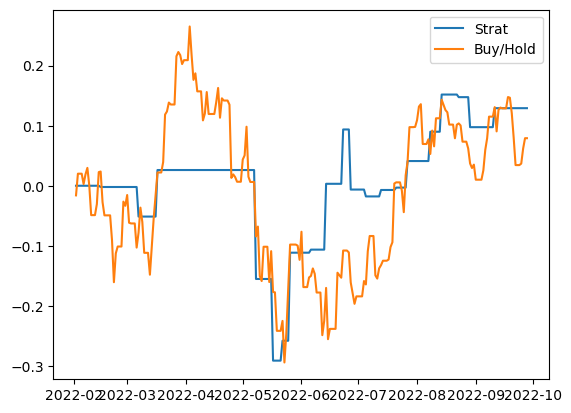

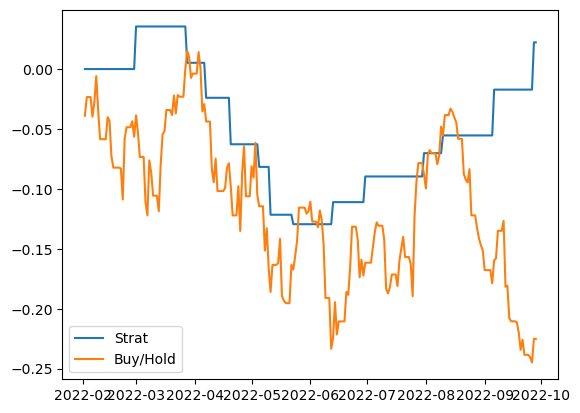

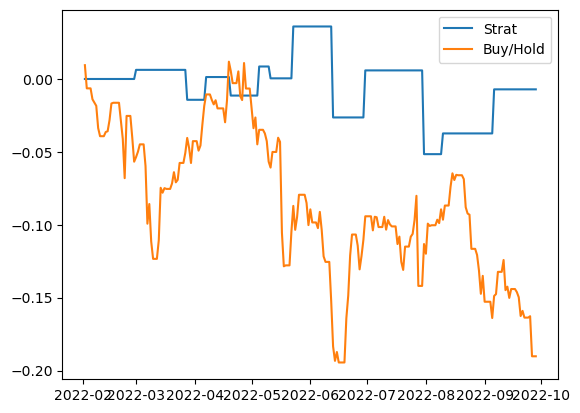

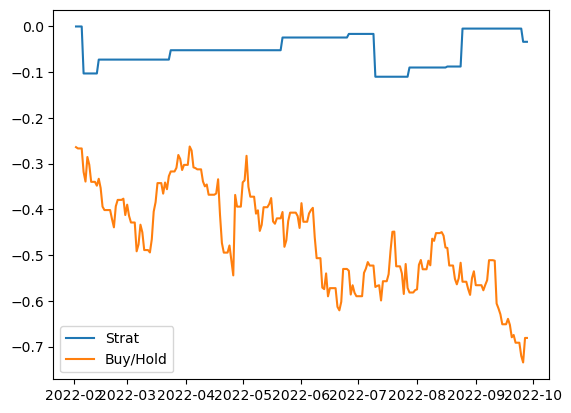

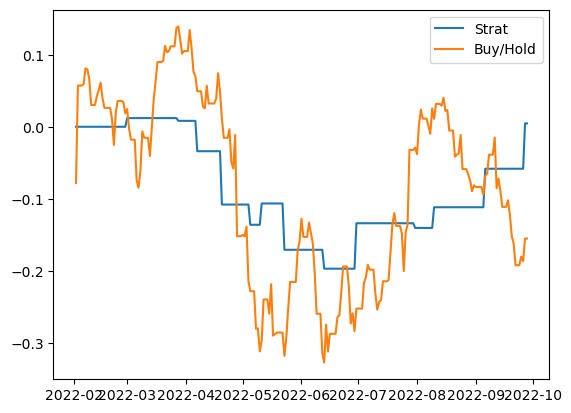

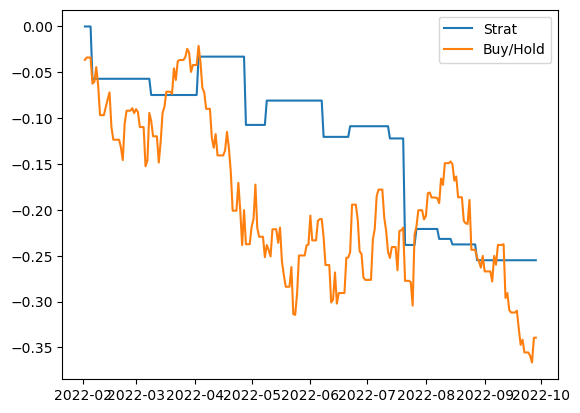

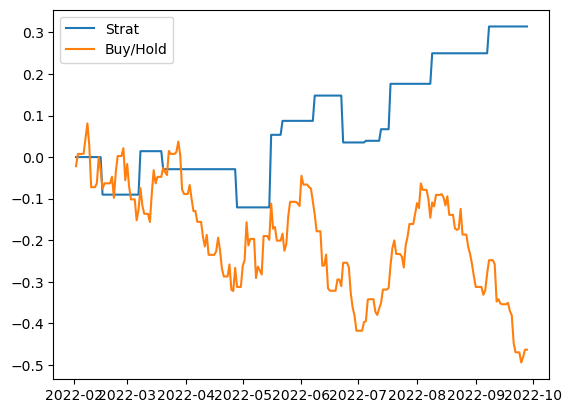

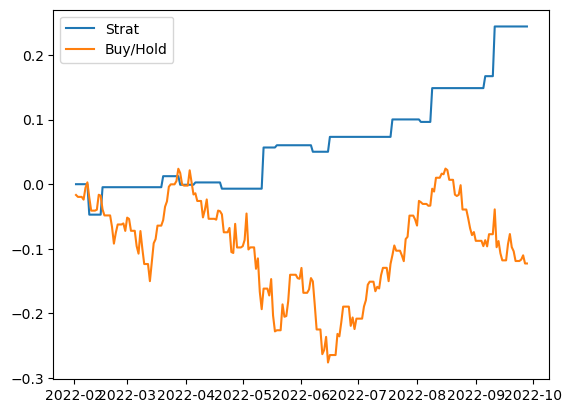

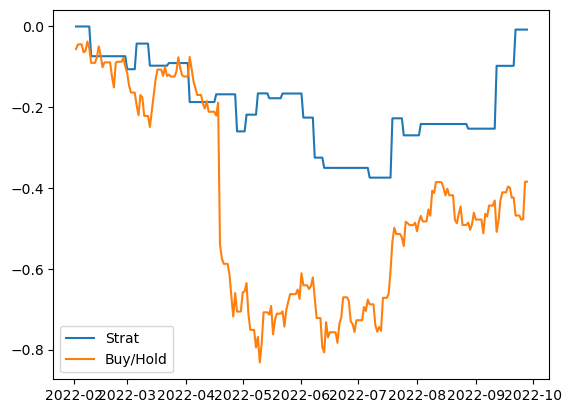

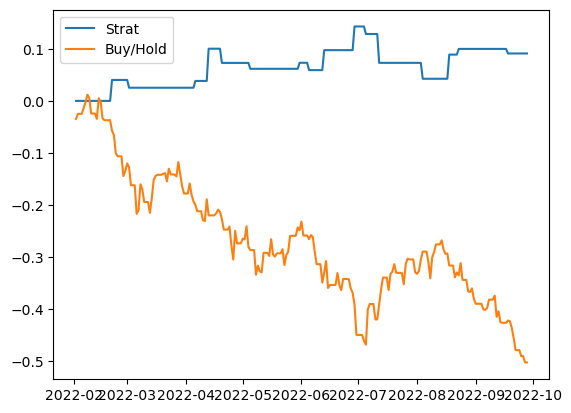

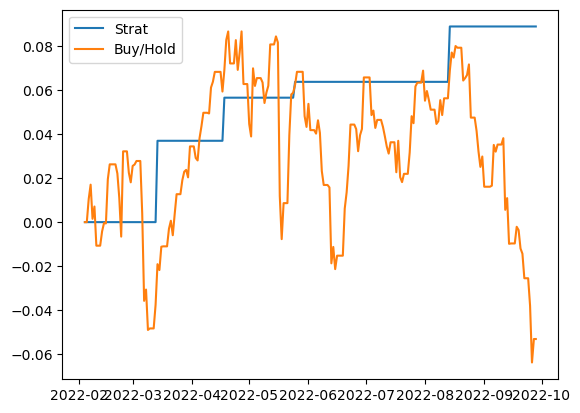

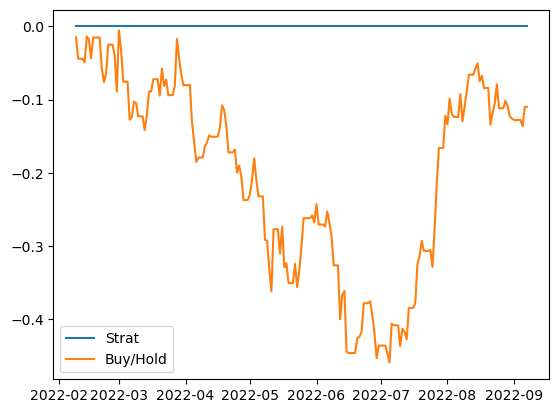

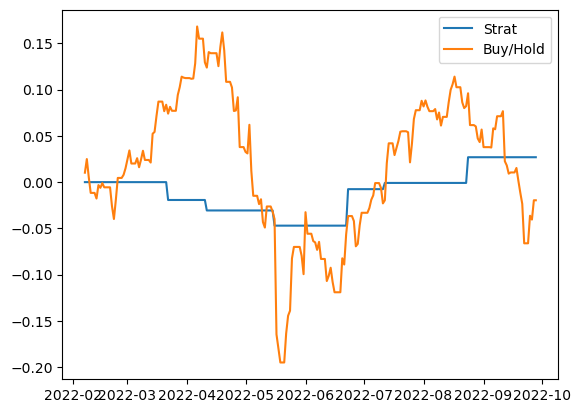

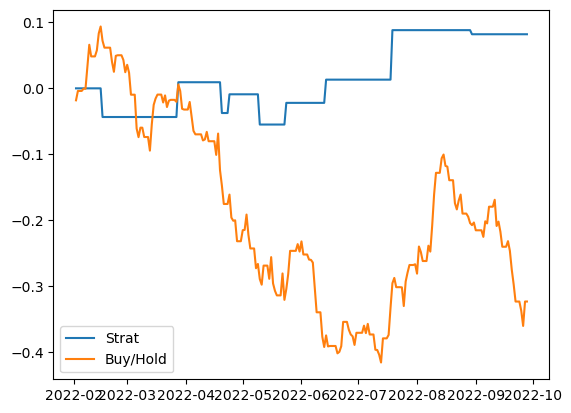

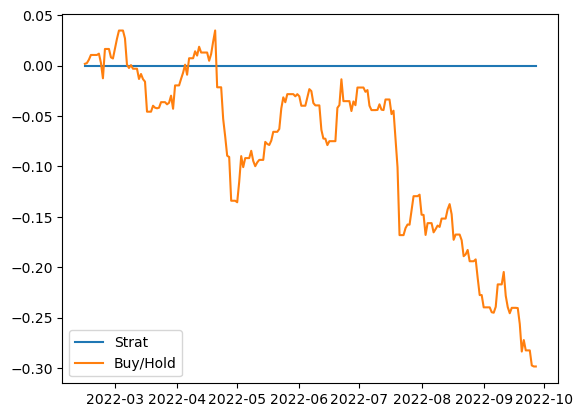

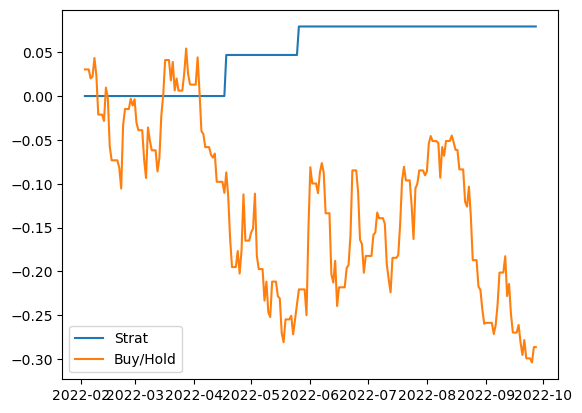

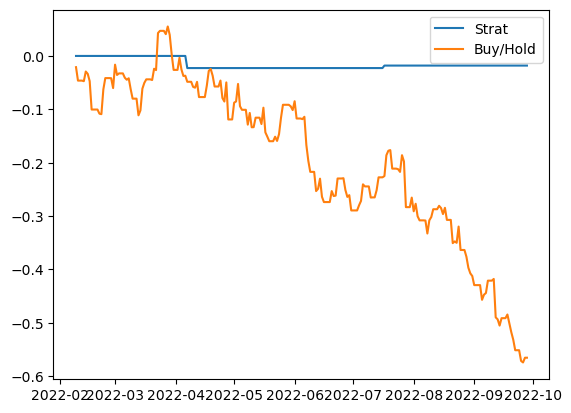

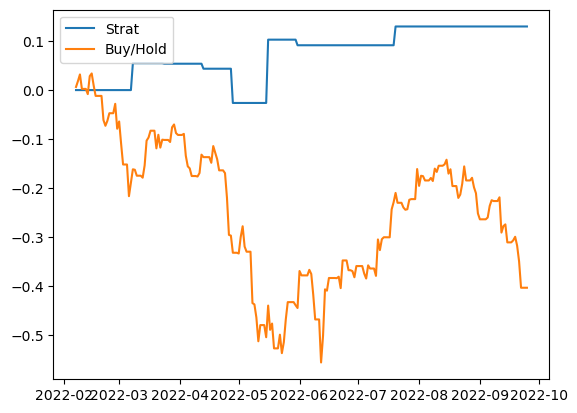

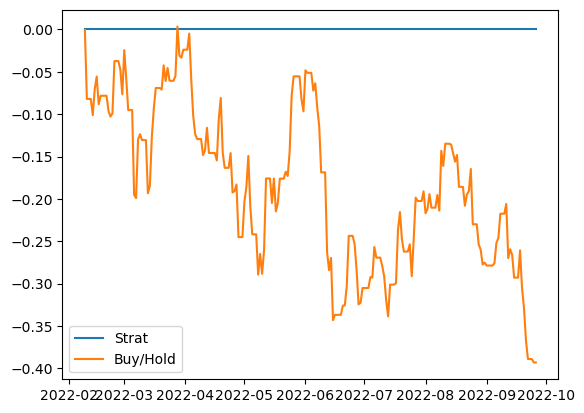

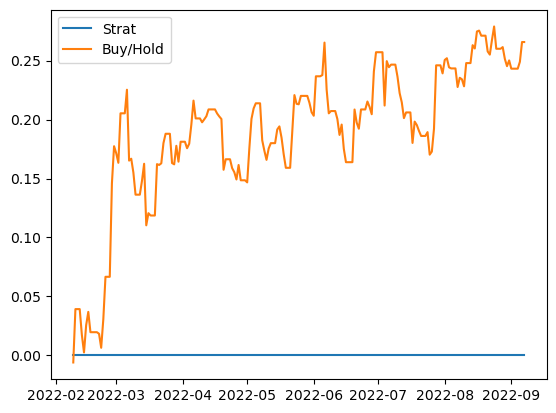

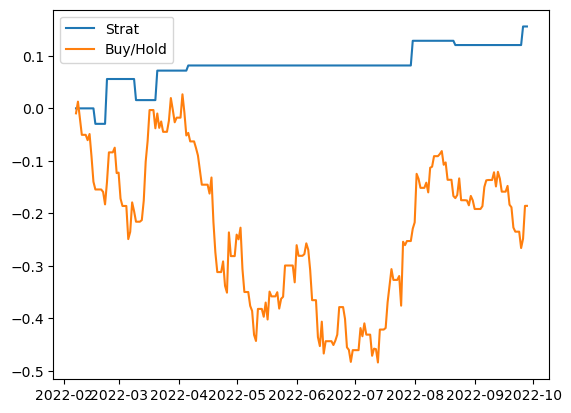

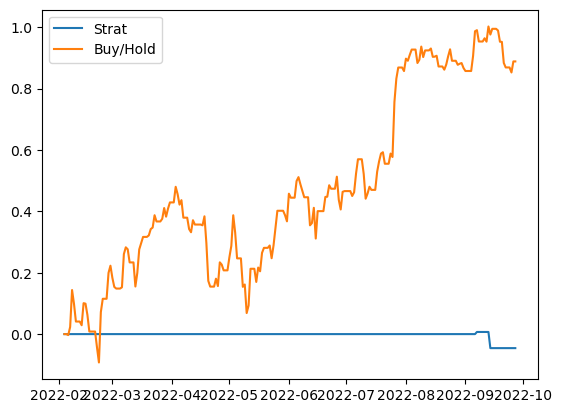

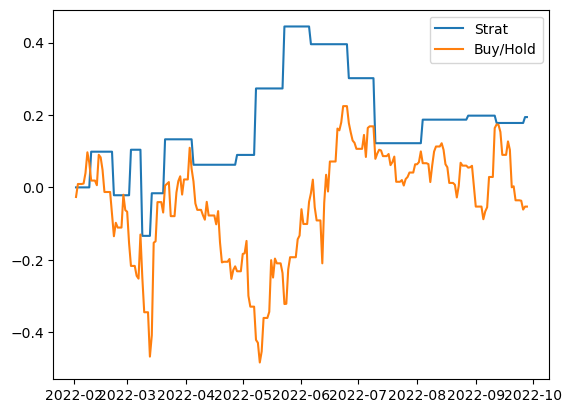

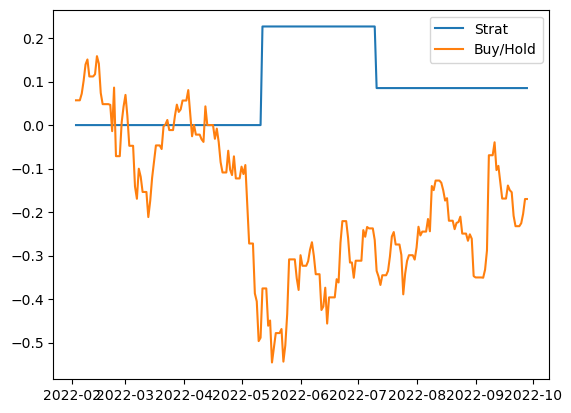

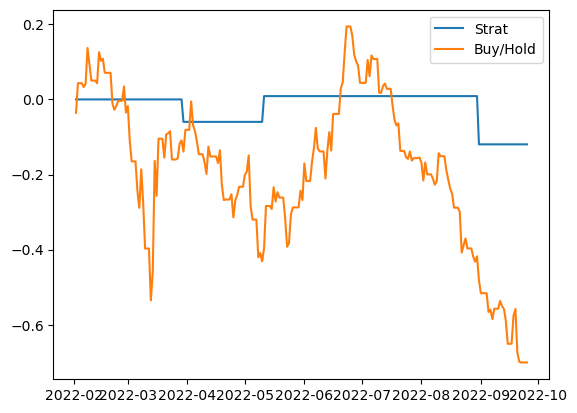

In [501]:
# For each stock, plot returns of the strategy vs returns of buy hold
import matplotlib.pyplot as plt
dict_ = {}
base_ = {}
cumu_returns = {}
for i in list_of_stocks:
    x, y, z, q, sh = sentiment_counter_strategy(i)
    if y > 20:
        dict_[i] = x
    else:
        dict_[i] = 'Not enough trades'
    base_[i] = sh
    plt.figure()
    plt.plot(z, label='Strat')
    plt.plot(q, label='Buy/Hold')
    plt.legend()


In [504]:
out = pd.DataFrame(dict_.values(), dict_.keys())
out.columns = ['Sharpe']
out['Buy Hold Sharpe'] = out.index.map(base_)
out['Strategy Sharpe'] = pd.to_numeric(out['Sharpe'], errors='coerce')


# Drop rows with NaN values in the column (i.e., rows with non-numeric values)
out = out.dropna()
out

,Sharpe,Buy Hold Sharpe,Strategy Sharpe
TSLA,0.265463,0.084443,0.265463
META,-0.426254,-1.417927,-0.426254
GOOG,-1.816197,-1.288286,-1.816197
AMD,0.900172,-1.048384,0.900172
AAPL,1.544474,-0.607921,1.544474
NFLX,-0.142843,-0.775294,-0.142843
TSM,0.417313,-1.954369,0.417313
NIO,0.321141,-0.127912,0.321141


In [505]:
out.describe()

,Buy Hold Sharpe,Strategy Sharpe
count,8.000000,8.000000
mean,-0.891956,0.132909
std,0.678056,0.993034
min,-1.954369,-1.816197
25%,-1.320696,-0.213696
50%,-0.911839,0.293302
75%,-0.487918,0.538028
max,0.084443,1.544474


### Just an initial analysis seems to outperform the buy and hold benchmark. We get an average sharpe of 0.13 across the basket of stocks, with a highest Sharpe of 1.54 for Apple


In [492]:
# # tsla_df = tweets_[tweets_['Stock Name'] == 'TSLA']

# # sentiment_counts = tsla_df.groupby(['Date', 'sentiment']).size().unstack(fill_value=0)
# # sentiment_counts

# # sentiment_counts.index = pd.to_datetime(sentiment_counts.index)

# # daily = sentiment_counts.resample('D').sum()

# daily.describe()

# import yfinance as yf

# tsla_price = yf.download('TSLA', daily.index.min().date(), daily.index.max().date())['Close']

# tsla_price.plot()

# # Naive Trading Strategy:

# # If > 5 positive tweets daily for 2 days, buy next day
# # Hold for 1 week and sell

# daily['positive ratio'] = daily['positive']/daily.sum(axis=1)

# daily['negative ratio'] = daily['negative']/daily.sum(axis=1)

# daily.describe()

# daily['trades'] = 0

# negative_ = 0.25
# positive_ = 0.53
# counter_negative = 0
# counter_positive = 0
# for i in range(len(daily)-1):
#     if daily.iloc[i,4] > 0.254696:
#         counter_negative +=1
#     if daily.iloc[i,3] > 0.531915:
#         counter_positive +=1
#     if counter_negative == 4:
#         daily.iloc[i+1,5] = -1
#         counter_positive = 0
#         counter_negative = 0
#     if counter_positive == 4:
#         daily.iloc[i+1,5] = +1
#         counter_positive = 0
#         counter_negative = 0

# daily

# z = pd.DataFrame(tsla_price)



# df2_filled = z.reindex(daily.index).fillna(method='ffill')
# df2_filled


# daily.index = daily.index
# daily['price'] = df2_filled

# daily['returns'] = daily.price.pct_change()

# daily['returns'] = daily['returns'].shift(-1)

# (daily['trades']*daily['returns']).cumsum().plot()

# print('Number of trades:', len(daily[daily['trades']!=0]))

# daily['day_returns'] = daily['price'].shift(-1)/daily['price'] -1

# (daily['trades']*daily['3day_returns']).cumsum().plot()

# import numpy as np
# daily['strat_rets'] = (daily['trades']*daily['day_returns'])
# risk_free_rate = 0.04
# sharpe_ratio = (np.mean(daily['strat_rets']*252) - risk_free_rate) / (np.std(daily['strat_rets'])*np.sqrt(252))

# sharpe_ratio